In [52]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab.grid import RasterModelGrid
from landlab.components import OverlandFlow, SinkFiller
from landlab.components import CRESTHH, map_gauge_loc_to_node
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link

In [2]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
basin_shp= basin_shp.set_crs('EPSG:4326')
basin_shp= basin_shp.to_crs('EPSG:32215')

In [3]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/CRM_Houston_NAm83/DEM_100m.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')

In [4]:
basin_dem= dem_region.rio.clip(basin_shp.geometry, basin_shp.crs).squeeze().sortby('y', ascending=True)

In [5]:
basin= RasterModelGrid(shape= basin_dem.squeeze().shape,
                       xy_spacing=np.diff(basin_dem.x.values)[0],
                       xy_of_lower_left= [basin_dem.x.values[0], basin_dem.y.values[0]]
                      )
basin.axis_units = ('m', 'm')

In [6]:
z= basin.add_field('topographic__elevation', basin_dem.values.astype(float), at="node", clobber=True, dtype=float)


In [7]:
sf= SinkFiller(basin, routing='D4')
sf.fill_pits()

In [8]:
def load_param(path, lons=basin_dem.x.values, lats=basin_dem.y.values):
    param= rioxarray.open_rasterio(path)
    param= param.rio.write_crs('EPSG:4326').rio.reproject('EPSG:32215')
    param= param.sel(x= lons, y=lats, method='nearest')
    return param.values
    

In [9]:
from landlab import imshow_grid_at_node

In [21]:
map_gauge_loc_to_node?

In [29]:
basin.status_at_node[basin.nodes_at_bottom_edge] = basin.BC_NODE_IS_FIXED_VALUE
basin.status_at_node[np.isclose(z, basin_dem._FillValue)] = basin.BC_NODE_IS_CLOSED
# basin.set_watershed_boundary_condition(z, nodata_value = basin_dem._FillValue)
# basin.set_watershed_boundary_condition_outlet_id(8954, 'topographic__elevation')
gauge_5900= (266648.7618,3316464.1819)
gauge_6000= (277287.3178,3311964.4192)
gauge_6180= (284362.476,3313541.542)
gauge_6500= (274446.6892,3305767.1611)
gauge_6700= (284219.573,3302832.615)
outlet_id= map_gauge_loc_to_node(basin, gauge_6700[0], gauge_6700[1], 'epsg:32215', 'epsg:32215')
basin.set_watershed_boundary_condition_outlet_id(8503, 'topographic__elevation')

gauged_id = [map_gauge_loc_to_node(basin, point[0], point[1], 'epsg:32215', 'epsg:32215') for point in [gauge_5900, gauge_6000, gauge_6180, gauge_6500]]

In [49]:
gauges= {'08075900': gauged_id[0], '08076000': gauged_id[1], '08076180': gauged_id[2], '08076500': gauged_id[3]}

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


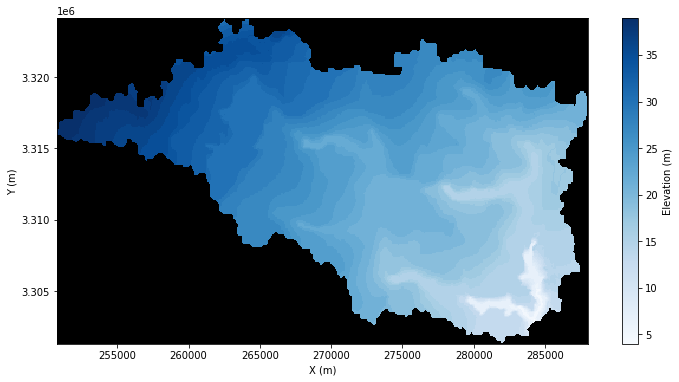

In [31]:
fig= plt.figure(figsize=(12,6))

imshow_grid_at_node(basin, z, colorbar_label='Elevation (m)', cmap='Blues')
plt.show();

In [ ]:
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/b_10m.tif')
_= basin.add_field('B', param, at="node", dtype=np.float32,clobber=True)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/wm_10m.tif')
_= basin.add_field('WM', param, at="node", units='mm',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/ksat.tif')
_= basin.add_field('Ksat', param, at="node", units='mm/hr',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/im.tif')
_= basin.add_field('IM', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/sm.20170826.120000.tif')
_= basin.add_field('SM0', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/friction/manningn.tif')
_= basin.add_field('friction_node', param, at="node",clobber=True, dtype=np.float32)
friction_link= map_mean_of_link_nodes_to_link(basin, 'friction_node')
_= basin.add_field('friction', friction_link.astype(np.float32), at="link",clobber=True, units='-')
_= basin.add_ones('KE',at='node', dtype= np.float32,clobber=True)

In [53]:
cresthh= CRESTHH(basin, proj='EPSG:32215',
                start= '20170826110000',
                end= '20170830000000',
                freq= '1H',
                precip_path='/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/mrms201708/',
                precip_freq='10T',
                precip_pattern='PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif',
                evap_path= '/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/evap/',
                evap_freq='1D',
                evap_pattern= 'cov_et%y%m%d.asc.tif',
                outlet= outlet_id,
                gauges= gauges,
                outlet_ts=True,
                reinfiltration=True,
                output_dir= 'data',
                output_vars= ['surface_water__depth', 'surface_water__discharge'],
                parallel=0
                )


In [54]:
cresthh.run()

time: 2017-08-26 11:02:58.325178
----------------------------
elapsed time: 0.00 hrs
time step: 178.33 sec
outlet depth: 0.00 m
SM: 54.3%
water surface gradient: 0.10
discharge: 0.00 m^3/s
-----------------------
time: 2017-08-26 12:00:18.784001
----------------------------
elapsed time: 0.00 hrs
time step: 44.83 sec
outlet depth: 0.02 m
SM: 60.6%
water surface gradient: 0.10
discharge: 0.11 m^3/s
-----------------------
time: 2017-08-26 13:00:04.436861
----------------------------
elapsed time: 0.00 hrs
time step: 31.88 sec
outlet depth: 0.02 m
SM: 73.5%
water surface gradient: 0.10
discharge: 0.00 m^3/s
-----------------------
time: 2017-08-26 14:00:09.855507
----------------------------
elapsed time: 0.01 hrs
time step: 19.36 sec
outlet depth: 0.09 m
SM: 84.5%
water surface gradient: 0.10
discharge: 0.08 m^3/s
-----------------------
time: 2017-08-26 15:00:15.549285
----------------------------
elapsed time: 0.01 hrs
time step: 17.30 sec
outlet depth: 0.08 m
SM: 86.6%
water surface 

time: 2017-08-28 02:00:03.258142
----------------------------
elapsed time: 0.19 hrs
time step: 9.03 sec
outlet depth: 0.39 m
SM: 94.2%
water surface gradient: 0.07
discharge: 31.71 m^3/s
-----------------------
time: 2017-08-28 03:00:03.014849
----------------------------
elapsed time: 0.20 hrs
time step: 8.98 sec
outlet depth: 0.38 m
SM: 94.2%
water surface gradient: 0.07
discharge: 34.21 m^3/s
-----------------------
time: 2017-08-28 04:00:08.897386
----------------------------
elapsed time: 0.20 hrs
time step: 8.92 sec
outlet depth: 0.38 m
SM: 94.2%
water surface gradient: 0.06
discharge: 37.09 m^3/s
-----------------------
time: 2017-08-28 05:00:00.427980
----------------------------
elapsed time: 0.21 hrs
time step: 8.72 sec
outlet depth: 0.42 m
SM: 94.2%
water surface gradient: 0.06
discharge: 46.93 m^3/s
-----------------------
time: 2017-08-28 06:00:03.357202
----------------------------
elapsed time: 0.22 hrs
time step: 8.58 sec
outlet depth: 0.42 m
SM: 94.2%
water surface gr

time: 2017-08-29 17:00:09.257311
----------------------------
elapsed time: 0.46 hrs
time step: 9.59 sec
outlet depth: 0.23 m
SM: 92.9%
water surface gradient: 0.06
discharge: 18.07 m^3/s
-----------------------
time: 2017-08-29 18:00:07.293269
----------------------------
elapsed time: 0.46 hrs
time step: 9.65 sec
outlet depth: 0.22 m
SM: 92.6%
water surface gradient: 0.06
discharge: 16.01 m^3/s
-----------------------
time: 2017-08-29 19:00:00.001553
----------------------------
elapsed time: 0.47 hrs
time step: 9.72 sec
outlet depth: 0.21 m
SM: 92.1%
water surface gradient: 0.06
discharge: 14.06 m^3/s
-----------------------
time: 2017-08-29 20:00:07.688532
----------------------------
elapsed time: 0.47 hrs
time step: 9.78 sec
outlet depth: 0.20 m
SM: 91.7%
water surface gradient: 0.07
discharge: 12.26 m^3/s
-----------------------
time: 2017-08-29 21:00:01.278400
----------------------------
elapsed time: 0.48 hrs
time step: 9.85 sec
outlet depth: 0.19 m
SM: 91.3%
water surface gr

In [55]:
cresthh.outlet

{'08075900': {'time': ['2017-08-26 11:00:00',
   '2017-08-26 12:00:00',
   '2017-08-26 13:00:00',
   '2017-08-26 14:00:00',
   '2017-08-26 15:00:00',
   '2017-08-26 16:00:00',
   '2017-08-26 17:00:00',
   '2017-08-26 18:00:00',
   '2017-08-26 19:00:00',
   '2017-08-26 20:00:00',
   '2017-08-26 21:00:00',
   '2017-08-26 22:00:00',
   '2017-08-26 23:00:00',
   '2017-08-27 00:00:00',
   '2017-08-27 01:00:00',
   '2017-08-27 02:00:00',
   '2017-08-27 03:00:00',
   '2017-08-27 04:00:00',
   '2017-08-27 05:00:00',
   '2017-08-27 06:00:00',
   '2017-08-27 07:00:00',
   '2017-08-27 08:00:00',
   '2017-08-27 09:00:00',
   '2017-08-27 10:00:00',
   '2017-08-27 11:00:00',
   '2017-08-27 12:00:00',
   '2017-08-27 13:00:00',
   '2017-08-27 14:00:00',
   '2017-08-27 15:00:00',
   '2017-08-27 16:00:00',
   '2017-08-27 17:00:00',
   '2017-08-27 18:00:00',
   '2017-08-27 19:00:00',
   '2017-08-27 20:00:00',
   '2017-08-27 21:00:00',
   '2017-08-27 22:00:00',
   '2017-08-27 23:00:00',
   '2017-08-28 00:

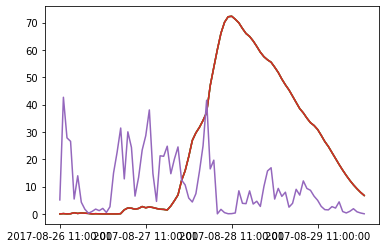

In [66]:
plt.plot(cresthh.outlet['08075900']['time'], cresthh.outlet['08075900']['Q'])
plt.xticks(cresthh.outlet['08075900']['time'][::24])
plt.plot(cresthh.outlet['08076000']['time'], cresthh.outlet['08076000']['Q'])
plt.xticks(cresthh.outlet['08076000']['time'][::24])
plt.plot(cresthh.outlet['08076180']['time'], cresthh.outlet['08076180']['Q'])
plt.xticks(cresthh.outlet['08076180']['time'][::24])
plt.plot(cresthh.outlet['08076500']['time'], cresthh.outlet['08076500']['Q'])

plt.plot(cresthh.outlet['08076500']['time'], cresthh.outlet['08076500']['P']);
plt.xticks(cresthh.outlet['08076500']['time'][::24]);

In [56]:
basin.field_values('node', 'surface_water__depth').reshape(basin.shape).shape

(276, 450)

In [153]:
basin.at_node['surface_water__depth'][:].max()

nan

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


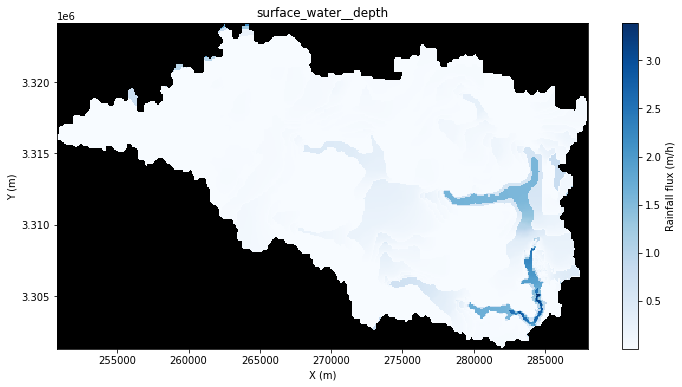

In [72]:
fig= plt.figure(figsize=(12,6))
imshow_grid_at_node(
        basin, 'surface_water__depth', cmap='Blues', colorbar_label='Rainfall flux (m/h)'
    )
plt.plot(gauge_6700[0], gauge_6700[1], markersize=100, color='r')

In [199]:
pd.Timedelta('1D').total_seconds()

86400.0

In [170]:
from datetime import datetime

In [175]:
(pd.to_datetime('20170825000000') - pd.to_datetime('19700101000000')).total_seconds()

1503619200.0